In [1]:
!nvidia-smi

Tue Oct 13 13:51:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0    67W /  N/A |   1134MiB /  6144MiB |     48%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [16]:
# ====== Regular Imports ======
import os
import numpy as np
import scipy as sp
import pandas as pd
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ======= Visualization ========
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# ======= Images ========
import visualizer
import cv2
from glob import glob
from PIL import Image
import albumentations as alb

# ========= SKLearn =========
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# ======== Transfer Learnin ======
from efficientnet.tfkeras import *
from tensorflow.keras.applications import ResNet50, Xception

# ======== TensorFlow ========
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.python.keras.layers.advanced_activations import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.constraints import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

print("All libraries successfully imported.")

All libraries successfully imported.


In [18]:
!nvidia-smi

Sun Oct 11 13:47:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5    11W /  N/A |   5188MiB /  6144MiB |     30%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [ ]:
base_path = "C:/Users/harsh/Desktop/Python/Projects/MRI Segmentation"
base_path2 = "D:/Datasets/Brain Cancer Detection"
data = pd.read_csv(f"{base_path}/kaggle_3m/data.csv")

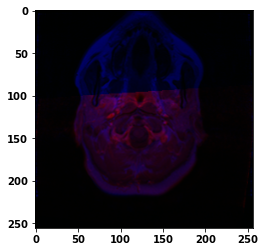

In [4]:
# ========================================== INSPECTING IMAGE DATA ==========================================

sample = f"{base_path}/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif"
sample_mask = f"{base_path}/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_mask.tif"

sample_img = cv2.imread(sample)
plt.imshow(sample_img)

In [5]:
# -----------------------------------------------------------------------------------------------------------
# ========================================== ORGANIZING IMAGE DATA ==========================================
# -----------------------------------------------------------------------------------------------------------

def extract_image_paths(base_path):
    train_files = []
    mask_files = glob(f'{base_path}/kaggle_3m/*/*_mask*')
    mask_files = [mask.replace("\\", "/") for mask in mask_files]

    for file in mask_files:
        train_files.append(file.replace("_mask", ""))

    return train_files, mask_files

def traintest_split(base_path, test_size, val_size):
    train_files, mask_files = extract_image_paths(base_path)

    df = pd.DataFrame(data={'images': train_files, 'masks': mask_files})
    train_set, test_set = train_test_split(df, test_size=test_size)
    train_set, val_set = train_test_split(train_set, test_size=val_size)

    return train_set, test_set, val_set

In [6]:
# -----------------------------------------------------------------------------------------------------------
# =========================================== IMAGE PREPROCESSING ===========================================
# -----------------------------------------------------------------------------------------------------------

def get_image_resolution(image):
    img = cv2.imread(image)
    height, width, clr_channel = img.shape
    resolution = [height, width, clr_channel]

    return resolution

def scan_image_abnormalities(base_path, base_img_resolution, base_msk_resolution):
    """[Scans directory for abnormalities in images]
    Args:
        base_path ([str]): [parent directory - the directory above the dataset dir]
        base_img_resolution([list]): [list in format - [height, width, channel] ]
        base_msk_resolution([list]): [list in format - [height, width, channel] ]

    Returns:
        [abnormal_image_properties]: [list of abnormal images and their heights, widths, and channels]
        [abnormal_mask_properties]: [list of abnormal masks and their heights, widths, and channels]
    """

    # Defining lists for appending paths of abnormal images, and their heights, widths, and channels
    ab_imgs, ab_im_h, ab_im_w, ab_im_c = [], [], [], []
    ab_masks, ab_msk_h, ab_msk_w, ab_msk_c = [], [], [], []

    train_files, mask_files = extract_image_paths(base_path)
    
    for img, mask in zip(train_files, mask_files):
        img_resolution = get_image_resolution(img)
        msk_resolution = get_image_resolution(mask)     

        if img_resolution != base_img_resolution:
            ab_imgs.append(img)
            if img_resolution[0] != 500: ab_im_h.append(img_resolution[0])
            elif img_resolution[1] != 500:ab_im_w.append(img_resolution[1])
            elif img_resolution[2] != 3: ab_im_c.append(img_resolution[1])

        if msk_resolution != base_msk_resolution:
            ab_masks.append(mask)
            if msk_resolution[0] != 500: ab_msk_h.append(msk_resolution[0])
            elif msk_resolution[1] != 500:ab_msk_w.append(msk_resolution[1])
            elif msk_resolution[2] != 3: ab_msk_c.append(msk_resolution[1])
        
    abnormal_image_properties = [ab_imgs, ab_im_h, ab_im_w, ab_im_c]
    abnormal_mask_properties = [ab_masks, ab_msk_h, ab_msk_w, ab_msk_c]

    return abnormal_image_properties, abnormal_mask_properties 


In [7]:
# -----------------------------------------------------------------------------------------------------------
# =========================================== IMAGE-DATA GENERATOR ==========================================
# -----------------------------------------------------------------------------------------------------------

def normalize_and_highlight(img,mask):
    # Normalizing
    img = img / 255
    mask = mask / 255

    # Darkening/Lightening highlights 
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


# Adopted From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(df, batch_size, augmentations, target_size,
                    image_color_mode="rgb", mask_color_mode="grayscale",
                    image_save_prefix="image", mask_save_prefix="mask",
                    save_to_dir=None, seed=777):
    
    image_datagen = ImageDataGenerator(**augmentations)
    mask_datagen = ImageDataGenerator(**augmentations)
    
    image_generator = image_datagen.flow_from_dataframe(
        df, x_col = "images",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        df, x_col = "masks",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = normalize_and_highlight(img, mask)
        yield (img,mask)

In [8]:
# -----------------------------------------------------------------------------------------------------------
# =========================================== MODEL CALLBACKS ===============================================
# -----------------------------------------------------------------------------------------------------------

def reducelronplateau():
    reducelronplateau = ReduceLROnPlateau(
        monitor='val_loss', factor=0.05, 
        patience=5, verbose=1, mode='auto',
        min_delta=0.0001, cooldown=0, min_lr=0.001)

    return reducelronplateau

def tensorboard(logs_dir):
    tensorboard = TensorBoard(
        log_dir="Tensorboard_Logs", histogram_freq=0, 
        write_graph=True, write_images=False, 
        update_freq='epoch', profile_batch=2, 
        embeddings_freq=0, embeddings_metadata=None)

    return tensorboard

def modelcheckpoint(checkpoint_filepath):
    modelcheckpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True, save_best_only=True,
        monitor='val_accuracy', mode='max')
    
    return modelcheckpoint

def earlystopping():    
    earlystopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=0, 
        verbose=0, mode='auto', baseline=None, 
        restore_best_weights=False)
    
    return earlystopping

def get_model_callbacks(tensorboard_logs_dir, model_checkpoint_filepath):
    callbacks = [
        reducelronplateau(),
        tensorboard(tensorboard_logs_dir),
        modelcheckpoint(model_checkpoint_filepath),
        earlystopping()
    ]

    return callbacks


In [9]:
# -----------------------------------------------------------------------------------------------------------
# ============================================= MODEL OPTIMIZERS ============================================
# -----------------------------------------------------------------------------------------------------------

def get_mixed_precision_opt(optimizer):
    return tf.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

In [10]:
# -----------------------------------------------------------------------------------------------------------
# ========================================= IMAGE SEGMENTATION MODEL ========================================
# -----------------------------------------------------------------------------------------------------------

def get_unet(input_shape):
    inputs = Input((input_shape[0], input_shape[1], input_shape[2]))

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    UNet = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return UNet

In [11]:
# loss and metrics
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [12]:
# -----------------------------------------------------------------------------------------------------------
# ============================================ PROJECT EXECUTION ============================================
# -----------------------------------------------------------------------------------------------------------

# ======= HYPERPARAMETERS =======
test_size = 0.1
val_size = 0.2
input_shape = (256, 256, 3)
base_img_resolution = [256, 256, 3]
base_msk_resolution = [256, 256, 3]

learning_rate = 0.0001
batch_size = 6
EPOCHS = 150
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-07
amsgrad = False

loss = 'binary_crossentropy'
metrics = ['accuracy']

In [13]:
# ===== IMAGE ABNORMALITIES =====
# abnrml_img_details, abnrml_msk_details = scan_image_abnormalities(base_path, base_img_resolution, base_msk_resolution)

# i, h, w, c = abnrml_img_details
# i1, h1, w1, c1 = abnrml_msk_details

# print(f"""
# Number of abnormal images: {len(i)} 
# Number of abnormal masks: {len(i1)}
# """)

In [14]:
# ======= MODEL COMPILING =======

optimizer = Adam(
    learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, 
    epsilon=epsilon, amsgrad=amsgrad, name='Adam'
)

mixed_precision_optimizer = get_mixed_precision_opt(optimizer)

UNet = get_unet(input_shape)

UNet.compile(optimizer=mixed_precision_optimizer, loss=loss, metrics=metrics)
# UNet.summary()

In [15]:
train_set, test_set, val_set = traintest_split(base_path, test_size, val_size)

In [17]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

In [19]:
# ======== MODEL TRAINING =======
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(train_set, batch_size,
                                train_generator_args,
                                target_size=(256, 256))
    
test_gener = train_generator(val_set, batch_size,
                                dict(),
                                target_size=(256, 256))
    


# decay_rate = learning_rate / EPOCHS
# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
# model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

callbacks = get_model_callbacks(f"{base_path}/Tensorboard_Logs", "checkpoint.hdf5")

history = UNet.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    # callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps = 10)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
  ...
    to  
  ['...']
Found 708 validated image filenames.
Found 708 validated image filenames.
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/150
 1/10 [==>...........................] - ETA: 33s

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-19-9429b6cc4dd9>:33) ]] [Op:__inference_distributed_function_5046]

Function call stack:
distributed_function


In [21]:
!nvidia-smi

Sun Oct 11 13:47:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5    11W /  N/A |   5518MiB /  6144MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  